# jaxeffort introduction

In this notebook we will show how to use some capabilities from `jaxeffort`.In this tutorial you will learn how to instantiate some trained emulators, run them and get jacobians as evaluated from AD systems.

We start by loading the required packages.

In [1]:
import numpy as np
import jaxeffort
import jax
import matplotlib.pyplot as plt
import json
plt.rcParams['text.usetex'] = True

Initializing neutrino interpolants with dual-grid strategy...
Creating F_interpolant grid...
Creating dFdy_interpolant grid...
F grid: 1100 points from 0.001000 to 1000.0
dFdy grid: 20000 points from 0.001000 to 1000.0
Computing F values...
Computing dFdy values...
Creating Akima interpolators...
Dual-grid interpolants initialized successfully!
jaxeffort: Initializing multipole emulators...
  Loading pybird_mnuw0wacdm...
  pybird_mnuw0wacdm: Loaded 3/3 multipoles (l=['0', '2', '4'])
  Loading velocileptors_lpt_mnuw0wacdm...
  velocileptors_lpt_mnuw0wacdm: Loaded 3/3 multipoles (l=['0', '2', '4'])
  Loading velocileptors_rept_mnuw0wacdm...
  velocileptors_rept_mnuw0wacdm: Loaded 3/3 multipoles (l=['0', '2', '4'])


`jaxeffort` comes batteries included with some trained emulators. They can be accessed by

In [2]:
P0 = jaxeffort.trained_emulators["pybird_mnuw0wacdm"]["0"]
P2 = jaxeffort.trained_emulators["pybird_mnuw0wacdm"]["2"]
P4 = jaxeffort.trained_emulators["pybird_mnuw0wacdm"]["4"]

You can get a description of the emulator, together with the parameters the emulator handles, by

In [3]:
P0.P11.emulator_description

{'author_email': 'bonici.marco@gmail.com',
 'miscellanea': 'The emulator has been trained using CLASS and pybird. The training dataset has been created by passing P_cb to PyBird, assuming there is only one massive neutrino.',
 'author': 'Marco Bonici',
 'parameters': 'z, ln10^10 As, ns, H0, omega_b, omega_c, Mnu, w0, wa.'}

You can see their input parameter ranges by (they are in the same order as in the above description)

In [4]:
P0.P11.in_MinMax

Array([[ 2.85016150e-01,  1.89999462e+00],
       [ 2.00002500e+00,  3.49999500e+00],
       [ 8.00001000e-01,  1.09999900e+00],
       [ 5.00001333e+01,  8.99998667e+01],
       [ 2.00000167e-02,  2.49999500e-02],
       [ 8.00003333e-02,  1.79999667e-01],
       [ 1.66666667e-06,  4.99998333e-01],
       [-2.99998833e+00,  4.99965000e-01],
       [-2.99998333e+00,  1.99998333e+00]], dtype=float64)

Now, let us come to the usage of `jaxeffort`. First, let us define some input cosmological parameters (we define here using a dictionary just because it is convenient later for the comparison with `pybird`).

We also define some dummy bias parameters. Here we also show how to compute the growth factor by using our built-in ODE solver (this is fundamental for the rescaling part).

In [5]:
b = np.ones(11)

cosmo_dict = {
    "ln10As": 3.2,
    "ns": 0.86,
    "H0": 67.,
    "ombh2": 0.022,
    "omch2": 0.12,
    "Mν": 0.06,
    "w0": -1.8,
    "wa": 0.3,
    "z": 1.2,
}


cosmo = jaxeffort.W0WaCDMCosmology(
            ln10As=cosmo_dict["ln10As"],
            ns=cosmo_dict["ns"],
            h=cosmo_dict["H0"]/100,
            omega_b=cosmo_dict["ombh2"],
            omega_c=cosmo_dict["omch2"],
            m_nu=cosmo_dict["Mν"],
            w0=cosmo_dict["w0"],
            wa=cosmo_dict["wa"]
        )

θ = np.array([cosmo_dict["z"], cosmo_dict["ln10As"], cosmo_dict["ns"], cosmo_dict["H0"], cosmo_dict["ombh2"], cosmo_dict["omch2"], cosmo_dict["Mν"], cosmo_dict["w0"],cosmo_dict["wa"]])
D, f = cosmo.D_f_z(cosmo_dict["z"])

After this prep work has been done, you just have to feed these three elements to `jaxeffort`.

In [6]:
km = 0.7
kr = 0.35
k = P0.P11.k_grid
b[4] /= km**2
b[5] /= kr**2
b[6] /= kr**2
b[7] = f.item() #required to slice 0D jax arrays, will fix in the future
nd = 3e-4
b[8] /= nd
b[9] /= nd
b[10] /= nd

In [7]:
P0.get_Pl(θ, b, D);

Ok, fine, but are these operations fast? Let's benchmark them.

In [8]:
%timeit cosmo.D_z(cosmo_dict["z"])#single redshift benchmark

404 μs ± 74.8 μs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [9]:
%timeit cosmo.D_z(np.linspace(0., 3., 30))#multiple redshift benchmark

537 μs ± 95.6 μs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [10]:
%timeit P0.get_Pl(θ, b, D)

35.9 μs ± 1.43 μs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


Great! Now, let us show how to compute the jacobian of these calculations! In the pure functional style approach that is leveraged by `jax`, let us define an utility function and then differentiate it.

In [11]:
# Define function for P0 that depends only on θ
def P0_func(theta):
    return P0.get_Pl(theta, b, D)

# Compute Jacobian: shape (74, 9) - 74 k-bins, 9 cosmological parameters
jacobian_P0 = jax.jacfwd(P0_func)(θ)
print(f"Jacobian shape: {jacobian_P0.shape}")

Jacobian shape: (74, 9)


Let us benchmark that as well

In [12]:
%timeit jax.jacfwd(P0_func)(θ)

1.03 ms ± 30.7 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


Let us now plot the results of these calculations

In [13]:
k = P0.P11.k_grid[:,1]

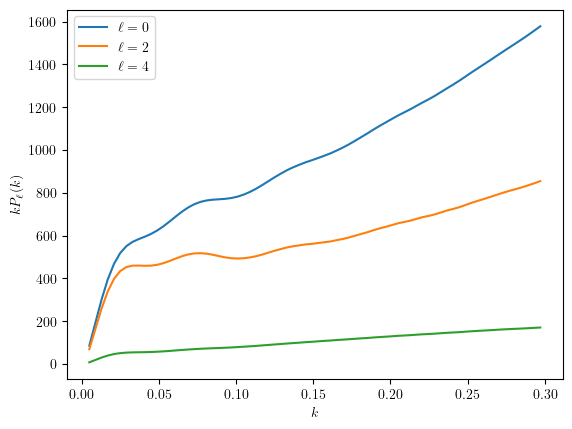

In [14]:
plt.plot(k, k*P0.get_Pl(θ, b, D), label = r"$\ell=0$")
plt.plot(k, k*P2.get_Pl(θ, b, D), label = r"$\ell=2$")
plt.plot(k, k*P4.get_Pl(θ, b, D), label = r"$\ell=4$")
plt.xlabel(r'$k$')
plt.ylabel(r'$kP_\ell(k)$')
plt.legend()

Text(0, 0.5, '$\\partial P_0(k)/\\partial\\alpha$')

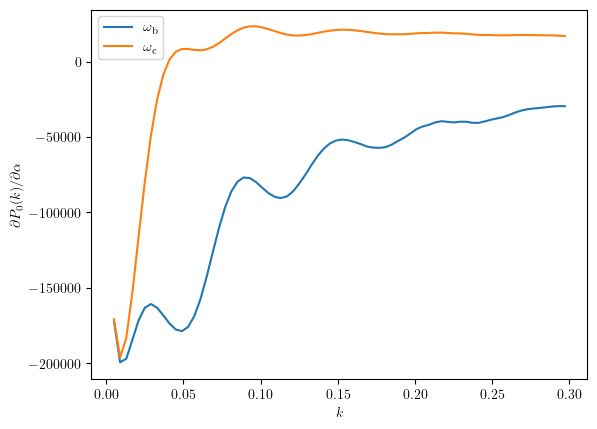

In [15]:
plt.plot(k, jacobian_P0[:,4], label = r"$\omega_\mathrm{b}$")
plt.plot(k, jacobian_P0[:,5], label = r"$\omega_\mathrm{c}$")
plt.legend()
plt.xlabel(r'$k$')
plt.ylabel(r'$\partial P_0(k)/\partial\alpha$')

Now, let us focus on some validations. How does it compare with the original `pybird`?

**Important**. Here everythin is set to use the exact same settings used to create the training dataset. If you want something different this is fine, but you will need a different emulator. If you want to chang the input cosmological parameters, just change the initial dictionary.

In [16]:
# Generate multipoles using CLASS + PyBird (like in training data generation)
from classy import Class
from pybird.correlator import Correlator

z = cosmo_dict["z"]

# Setup CLASS parameters
cosmo_params = {
    "output": "mPk",
    "P_k_max_h/Mpc": 20.0,
    "z_pk": "0.0,3.",
    "h": cosmo_dict["H0"] / 100,
    "omega_b": cosmo_dict["ombh2"],
    "omega_cdm": cosmo_dict["omch2"],
    "ln10^{10}A_s": cosmo_dict["ln10As"],
    "n_s": cosmo_dict["ns"],
    "tau_reio": 0.0568,
    "N_ur": 2.033,
    "N_ncdm": 1,
    "m_ncdm": cosmo_dict["Mν"],
    "use_ppf": "yes",
    "w0_fld": cosmo_dict["w0"],
    "wa_fld": cosmo_dict["wa"],
    "fluid_equation_of_state": "CLP",
    "cs2_fld": 1.,
    "Omega_Lambda": 0.,
    "Omega_scf": 0.
}

# Initialize CLASS and compute linear power spectrum
M = Class()
M.set(cosmo_params)
M.compute()

# Generate k values and compute linear power spectrum
kk = 10 ** np.linspace(-5, 0, 200)
pk_lin = [M.pk_cb(k * M.h(), z) * M.h()**3 for k in kk]

# Get growth factors
D1 = M.scale_independent_growth_factor(z)
f1 = M.scale_independent_growth_factor_f(z)

# Initialize PyBird Correlator
N = Correlator()
dk = 0.004
kd = np.arange(0.005, 0.3, dk)

# Set correlator parameters
N.set({
    "output": "bPk",
    "multipole": 3,
    "kmax": 0.3,
    "xdata": kd,
    "km": 0.7,
    "kr": 0.35,
    "nd": 3e-4,
    "eft_basis": "eftoflss",
    "with_stoch": True,
    "with_bias": False,
    "with_resum": True
})

# Compute correlator
N.compute({
    "kk": kk,
    "pk_lin": pk_lin,
    "f": f1
})

# Get the multipole components (matching training data)
P11l = N.bird.P11l
Ploopl = N.bird.Ploopl
Pctl = N.bird.Pctl

eft_params = {
    'b1': 1., 'b2': 1.0, 'b3': 1., 'b4': 1.,
    'cct': 1., 'cr1': 1., 'cr2': 1.,
    'ce0': 1.0, 'ce1': 1.0, 'ce2': 1.
}

bPk = N.get(eft_params)

print(f"CLASS+PyBird computation complete!")

CLASS+PyBird computation complete!


In [17]:
# Compare emulator vs CLASS+PyBird
# Compute with emulator
P0_emu = P0.get_Pl(θ, b, D)
P2_emu = P2.get_Pl(θ, b, D)
P4_emu = P4.get_Pl(θ, b, D)

Now, let us compare the two results! We will show both the two lines in the same plot and the percentage residuals.

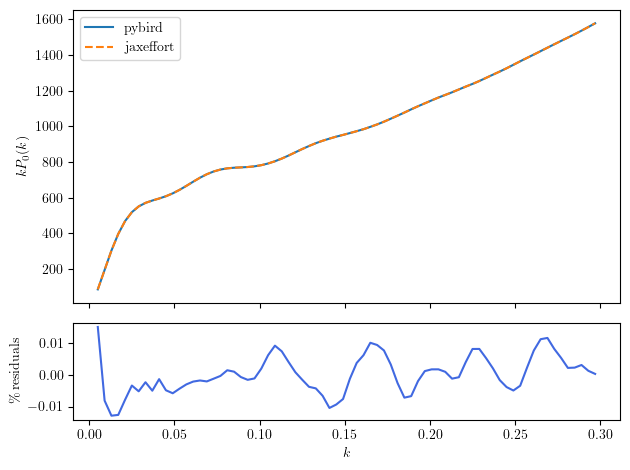

In [18]:
ratio_effort = P0_emu/bPk[0,:]
fig, (ax_top, ax_bot) = plt.subplots(
    2, 1,
    sharex=True,
    gridspec_kw={"height_ratios": [3, 1]},  # top three times taller
)

# ─── Top panel: power spectra ────────────────────────────────
ax_top.plot(k, k*bPk[0,:], label=r'$\mathrm{pybird}$')
ax_top.plot(k, k*(P0_emu), label=r'$\mathrm{jaxeffort}$', linestyle ="--")
ax_top.set_ylabel(r'$kP_0(k)$')
ax_top.legend()

# ─── Bottom panel: ratio ─────────────────────────────────────
ax_bot.plot(k, 100*(1-ratio_effort), color='royalblue')
ax_bot.set_xlabel(r'$k$')
ax_bot.set_ylabel(r'$\%\,\mathrm{residuals}$')

plt.tight_layout()
plt.show()

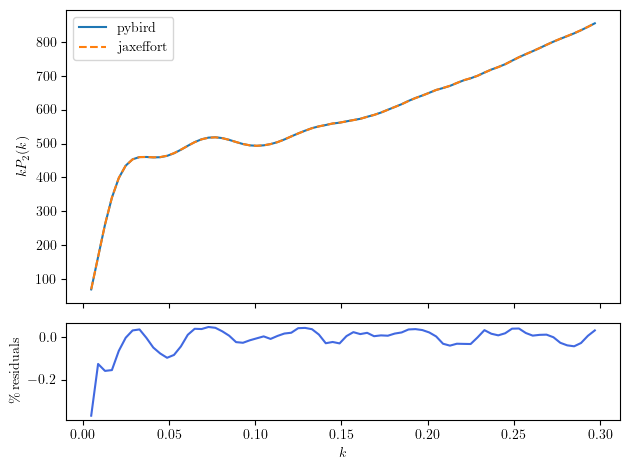

In [19]:
#ratio_pybird = (Pk_stoch[1]+P2_pybird)/bPk[1,:]
ratio_effort = (P2_emu)/bPk[1,:]
fig, (ax_top, ax_bot) = plt.subplots(
    2, 1,
    sharex=True,
    gridspec_kw={"height_ratios": [3, 1]},  # top three times taller
)

# ─── Top panel: power spectra ────────────────────────────────
ax_top.plot(k, k*bPk[1,:], label=r'$\mathrm{pybird}$')
ax_top.plot(k, k*(P2_emu), label=r'$\mathrm{jaxeffort}$', linestyle ="--")
ax_top.set_ylabel(r'$kP_2(k)$')
ax_top.legend()

# ─── Bottom panel: ratio ─────────────────────────────────────
ax_bot.plot(k, 100*(1-ratio_effort), color='royalblue')
ax_bot.set_xlabel(r'$k$')
ax_bot.set_ylabel(r'$\%\,\mathrm{residuals}$')

plt.tight_layout()
plt.show()

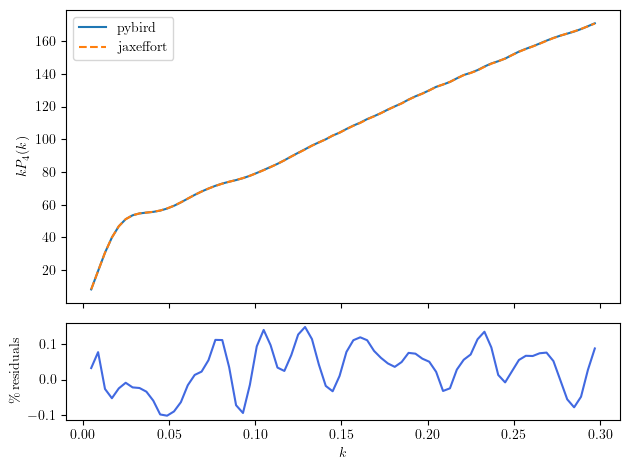

In [20]:
ratio_effort = P4_emu/bPk[2,:]
fig, (ax_top, ax_bot) = plt.subplots(
    2, 1,
    sharex=True,
    gridspec_kw={"height_ratios": [3, 1]},  # top three times taller
)

# ─── Top panel: power spectra ────────────────────────────────
ax_top.plot(k, k*bPk[2,:], label=r'$\mathrm{pybird}$')
ax_top.plot(k, k*P4_emu, label=r'$\mathrm{jaxeffort}$', linestyle ="--")
ax_top.set_ylabel(r'$kP_4(k)$')
ax_top.legend()

# ─── Bottom panel: ratio ─────────────────────────────────────
ax_bot.plot(k, 100*(1-ratio_effort), color='royalblue')
ax_bot.set_xlabel(r'$k$')
ax_bot.set_ylabel(r'$\%\,\mathrm{residuals}$')

plt.tight_layout()
plt.show()